# AutoEncoders for MD Analysis tutorial using BioExcel Building Blocks (biobb)

***
This tutorial involves the use of a **multilayer AutoEncoder (AE)** for **feature extraction** and **pattern recognition** by analyzing **Molecular Dynamic Simulations**, step by step, using the **BioExcel Building Blocks library (biobb)**.

The workflow begins with **featurization** using `MDFeaturizer` to extract structural descriptors (e.g., distances, angles, dihedrals, or Cartesian coordinates) from MD trajectories. Next, `buildModel` constructs a **multilayer AutoEncoder architecture**. The model is then trained with `trainModel` to **learn the dynamics** and **compressed representation** of **conformational dynamics**. After training, `evaluateModel` assesses reconstruction accuracy and latent space quality (using different datasets). Finally, `generatePlumed` converts the trained model into a **PLUMED-compatible format** (*.ptc*) and generates bias-ready input files for **enhanced sampling simulations**. This pipeline enables analysis with autoencoders for anomaly detection, identifying rare or perturbed dynamics, dynamical differences mapping, and the extration of  **collective variables (CVs)** for **enhanced sampling simulations**.

***

**MD simulations** were obtained from the [MDDB Database](https://mmb-dev.mddbr.eu/)
* **Replicase polyprotein 1ab** (PDB: [6W9C](https://www.rcsb.org/structure/6W9C)):
   1. **apo form**    (No ligands)
   2. **holo form** (Ligand: [3KB](https://www.rcsb.org/ligand/3KB)).

***


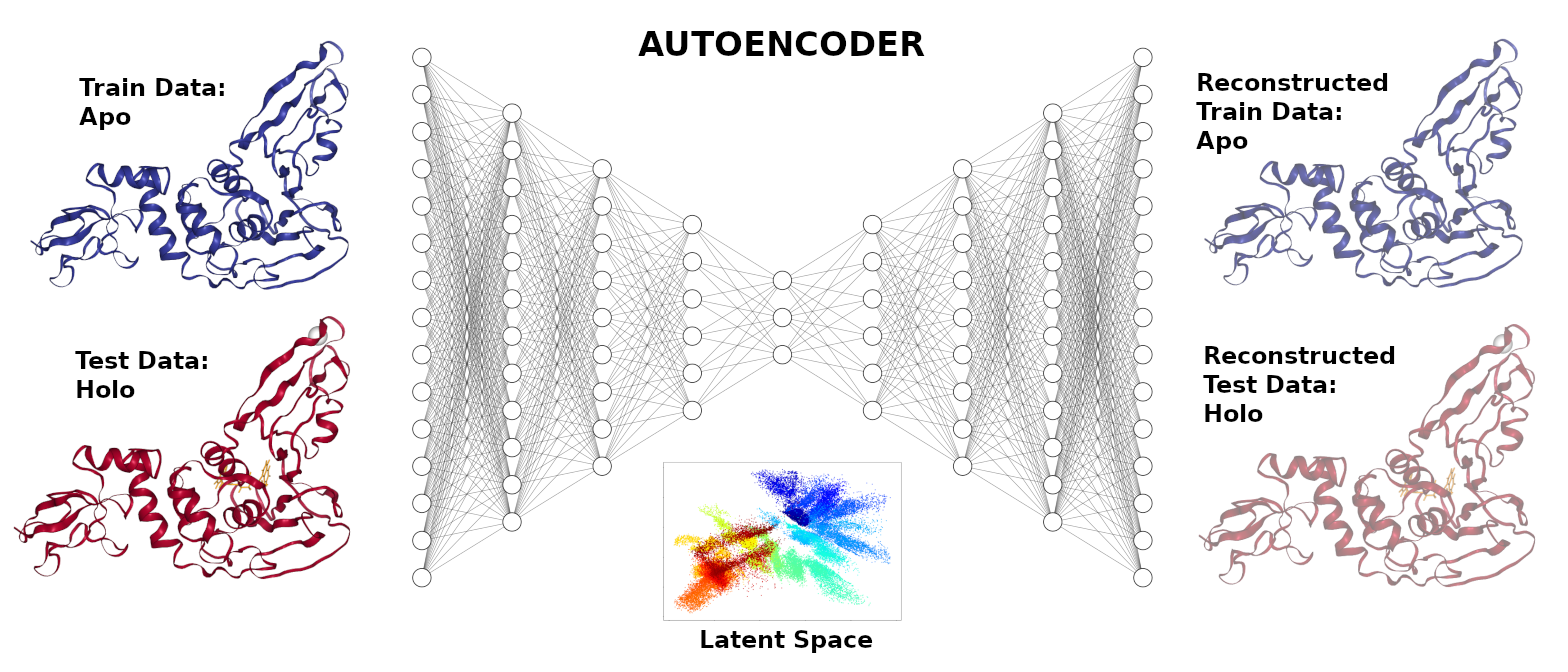

***
## Settings

### Biobb modules used

* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch): module collection to create and train ML & DL models using the popular PyTorch Python library.

### Auxiliary libraries used

* [jupyter](https://jupyter.org/): Free software, open standards, and web services for interactive computing across all programming languages.
* [nglview](http://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
* [numpy](https://numpy.org/): The fundamental package for scientific computing with Python.
* [mdtraj](https://www.mdtraj.org/): Read, write and analyze MD trajectories with only a few lines of Python code.
* [requests](https://requests.readthedocs.io/en/latest/): Requests is an elegant and simple HTTP library for Python, built for human beings.
* [matplotlib](https://matplotlib.org/): Matplotlib is a comprehensive library for creating static, animated, and interactive visualizations in Python.

> **IMPORTANT**: if your computer is a **mac ARM**, please be sure that the chosen architecture in conda is **ARM**. If not sure, type the following instruction in your terminal **before** starting the creation of the **environment**: <br>
`conda config --env --set subdir osx-arm64` <br>
This instruction ensures that the installed **torch** dependency will match your **architecture**.

### Conda Installation and Launch

```console
git clone https://github.com/bioexcel/biobb_wf_autoencoder.git
cd biobb_wf_autoencoder
conda env create -f conda_env/environment.yml
conda activate biobb_wf_autoencoder
jupyter-notebook biobb_wf_autoencoder/notebooks/biobb_wf_autoencoder.ipynb
```

***
## Pipeline steps
 1. [Input Parameters](#input)
 2. [Featurization of Training dataset](#featurize1)
 3. [Build Model](#build-model)
 4. [Train Model](#train-model)
 5. [Featurization of Evaluation dataset](#featurize2)
 6. [Evaluate Model](#evaluate-model)   
 7. [Case Study: Dynamical Differences Mapping](#case-study1)
 8. [Extract CV & Generate Plumed File](#cv-plumed)
 9. [Questions & Comments](#questions)

***
<img src="https://bioexcel.eu/wp-content/uploads/2019/04/Bioexcell_logo_1080px_transp.png" alt="Bioexcel2 logo"
	title="Bioexcel2 logo" width="400" />
***


## Initializing colab
The two cells below are used only in case this notebook is executed via Google Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import sys
REPO_URL = "https://github.com/bioexcel/biobb_wf_autoencoder.git"
repo_name = REPO_URL.split('/')[-1].split('.')[0]
# Clone repository
if not os.path.exists(repo_name):
  !git clone $REPO_URL
os.chdir(repo_name)

!apt install gromacs &> /dev/null
!pip install mlcolvar mdtraj biobb_common biobb_gromacs nglview==3.0.8 ipywidgets==7.7.2 &> /dev/null
!pip install git+https://github.com/bioexcel/biobb_analysis.git &> /dev/null
!pip install git+https://github.com/bioexcel/biobb_pytorch.git &> /dev/null
from google.colab import output
output.enable_custom_widget_manager()

Cloning into 'biobb_wf_autoencoder'...
remote: Enumerating objects: 118, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (79/79), done.
remote: Total 118 (delta 25), reused 111 (delta 21), pack-reused 0 (from 0)
Receiving objects: 100% (118/118), 1.98 MiB | 6.34 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [ ]:
# # Only executed when using google colab
# import sys
# from google.colab import drive
# if 'google.colab' in sys.modules:
#   drive.mount('/content/drive')
#   !git clone https://github.com/bioexcel/biobb_wf_autoencoder.git
#   !pip install -q condacolab
#   import condacolab
#   condacolab.install()

In [ ]:
# if 'google.colab' in sys.modules: 
#   # Install conda environment
#   !mamba env update -n base -f biobb_wf_autoencoder/conda_env/environment.yml
#   # Fix Python path to prioritize conda packages
#   conda_path = '/usr/local'
#   sys.path.insert(0, f'{conda_path}/lib/python3.11/site-packages')
#   # Enable widgets for colab
#   from google.colab import output 
#   output.enable_custom_widget_manager() 
#   # Change working dir
#   import os 
#   os.chdir("biobb_wf_autoencoder/biobb_wf_autoencoder/notebooks") 
#   print(f"New working directory: {os.getcwd()}")

***
<a id="input"></a>
## Input parameters

**Input parameters** needed:
  - **Training Data**:
    - **trj_in**: Path to input XTC trajectory file.
    - **str_in**: Path to input PDB topology file.
  - **Testing Data**:
    - **test_trj_in**: Path to input XTC trajectory file.
    - **test_str_in**: Path to input PDB topology file.


In [1]:
# Importing libraries
import numpy as np
import mdtraj as md
import nglview as nv
from biobb_pytorch.mdae import plots
import requests
from pathlib import Path

# Trajectory and structure files for training
trj_in = "trajs/6W9C_apo.xtc"
str_in = "trajs/6W9C_apo.pdb"

# Trajectory and structure files for testing
test_trj_in = "trajs/6W9C_holo.xtc"
test_str_in = "trajs/6W9C_holo.pdb"

***
<a id="featurize1"></a>
## Featurization of Training dataset

**Downloading** the **trajectory** and **structure** for **Training**.

Trajectories where obtained from the [MDDB database](https://mmb-dev.mddbr.eu/#/).


In [3]:
# Downloading trajectory and structure for training
traj_train_URL = "https://mmb.mddbr.eu/api/rest/v1/projects/MCV1900210/trajectory?format=xtc&frames=1-10000&selection=backbone%20and%20.CA"
pdb_train_URL = "https://mmb.mddbr.eu/api/rest/v1/projects/MCV1900210/structure?selection=backbone%20and%20.CA"
traj_train_path = trj_in
structure_train_path = str_in
Path(traj_train_path).parent.mkdir(parents=True, exist_ok=True)
req = requests.get(pdb_train_URL, allow_redirects=True)
open(structure_train_path, 'wb').write(req.content)
req = requests.get(traj_train_URL, allow_redirects=True)
open(traj_train_path, 'wb').write(req.content)

# Load trajectory
train_traj = md.load(traj_train_path, top=structure_train_path)

Visualizing the **training trajectory** using **NGL**:

In [3]:
# Show trajectory
view = nv.show_mdtraj(train_traj)
view

NGLWidget(max_frame=9999)

### Fit the trajectory

The **BioBB Analysis** tools are used to properly align the system to the **apo** structure.


***
**Biobb modules** used:
* [biobb_analysis](https://github.com/bioexcel/biobb_analysis)

***

In [4]:
from biobb_analysis.gromacs.gmx_image import gmx_image

traj_train_fit_path = "trajs/6W9C_apo_fit.xtc"

prop = {
    'fit_selection': 'Backbone',
    'output_selection': 'System',
    'center': False,
    'fit': 'rot+trans'
}

gmx_image(input_traj_path=traj_train_path,
          input_top_path=structure_train_path,
          output_traj_path=traj_train_fit_path,
          properties=prop)

2026-01-28 12:38:26,727 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_image Version: 4.2.0
2026-01-28 12:38:26,730 [MainThread  ] [INFO ]  Directory successfully created: /home/pzanders/Documents/BSC/BioExcel/biobb/biobb_wf_autoencoder/biobb_wf_autoencoder/notebooks/sandbox_7e7997e0-740f-48a1-82a8-a78bed33197c
2026-01-28 12:38:26,730 [MainThread  ] [INFO ]  Copy to stage: /home/pzanders/Documents/BSC/BioExcel/biobb/biobb_wf_autoencoder/biobb_wf_autoencoder/notebooks/trajs/6W9C_apo.xtc --> sandbox_7e7997e0-740f-48a1-82a8-a78bed33197c
2026-01-28 12:38:26,741 [MainThread  ] [INFO ]  Copy to stage: /home/pzanders/Documents/BSC/BioExcel/biobb/biobb_wf_autoencoder/biobb_wf_autoencoder/notebooks/trajs/6W9C_apo.pdb --> sandbox_7e7997e0-740f-48a1-82a8-a78bed33197c
2026-01-28 12:38:26,744 [MainThread  ] [INFO ]  Copy to stage: /home/pzanders/Documents/BSC/BioExcel/biobb/biobb_wf_autoencoder/biobb_wf_autoencoder/notebooks/09a316af-95d7-46e9-b310-4a1f72ac8e7c.stdin --> sandbox_7e7997e

2026-01-28 12:38:27,462 [MainThread  ] [INFO ]               :-) GROMACS - gmx trjconv, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pasca

2026-01-28 12:38:27,475 [MainThread  ] [INFO ]  Removed: ['/home/pzanders/Documents/BSC/BioExcel/biobb/biobb_wf_autoencoder/biobb_wf_autoencoder/notebooks/sandbox_7e7997e0-740f-48a1-82a8-a78bed33197c', '/home/pzanders/Documents/BSC/BioExcel/biobb/biobb_wf_autoencoder/biobb_wf_autoencoder/notebooks/09a316af-95d7-46e9-b310-4a1f72ac8e7c.stdin']
2026-01-28 12:38:27,476 [MainThread  ] [INFO ]  


0

### MD Featurization

**Input parameters** needed:

* **input_trajectory_path** *(str)*: Path to the input train data file (i.e. pdb, dcd).
* **input_topology_path** *(str)*: Path to the input model file (i.e. pdb).
* **output_dataset_pt_path** *(str)*: Path to the output model file.
* **output_stats_pt_path** *(str)*: Path to the output model statistics file.

**properties parameters**:
>* **cartesian** (*dict*): select the atoms for obtaining cartesian coordinates
>* **distances** (*dict*): select the atoms for obtaining distances
>* **angles** (*dict*): select the atoms for obtaining angles
>* **dihedrals** (*dict*): select the atoms for obtaining dihedrals
>* **options** (*dict*):
    > * timelag (*int*)
    > * norm_in (*str*)



***
**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***

In [8]:
from biobb_pytorch.mdae.mdfeaturizer import MDFeaturizer

# Input files
trajectory_file = traj_train_fit_path
topology_file = structure_train_path

# Output files
output_dataset_file = "6W9C_apo.pt"
output_stats_file = "6W9C_apo_stats.pt"

properties = {
    'cartesian': {'selection': 'name CA'},

    'remove_tmp': True,
    'disable_sandbox': True,
    'disable_logs': True,
}

MDFeaturizer(
    input_trajectory_path=trajectory_file,
    input_topology_path=topology_file,
    output_dataset_pt_path=output_dataset_file,
    output_stats_pt_path=output_stats_file,
    properties=properties
)

/usr/local/lib/python3.12/dist-packages/biobb_common/tools/file_utils.py:817: UserWarning: biobb_pytorch.mdae.mdfeaturizer input_trajectory_path: trajs/6W9C_apo_fit.xtc extension is not in the valid extensions list: ['dcd']. If you want to suppress this message, please set the check_extensions property to False
  warnings.warn(not_valid_extension_error_string)


0

***
<a id="build-model"></a>
## Build Model

**Input parameters** needed:

* **input_stats_pt_path** *(str)* : Dataset statistics and information file generated using the MDFeaturizer module. Needed for model construction.
* **output_model_pth_path** *(str)* : Output model file. Outputs pretrained model.

**Properties parameters:**
> * **model_type** *(str)* : Autoregressive model type. Options: AutoEncoder, VariationalAutoEncoder, GaussianMixtureVariationalAutoEncoder, CNNAutoEncoder (molearn), SPIB.
>* **n_cvs** *(int)* : Latent space dimension.
>* **encoder_layers** *(list | int)* : Dimension of encoder layers.
>* **decoder_layers** *(list | int)* : Dimension of encoder layers.
>* **options** :
 > >   - **encoder** *(dict)* : Options of the encoder layers. i.e. activation functions, dropout, batchnorm
 > >   - **decoder** *(dict)* : Options of the decoder layers. i.e. activation functions, dropout, batchnorm
 > >   - **optimizer** *(dict)* : Optons for the optimizer. i.e. type, learning rate, weight_decay, etc.
 > >   - **loss_function** *(dict)* : Select loss function (model specific).


***
**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***

In [9]:
from biobb_pytorch.mdae.build_model import buildModel

input_stats_path = "6W9C_apo_stats.pt"
output_model_pth_file = "model.pth"

model = "AutoEncoder"
latent_dim = 3
encoder_hidden_layers = [933, 747, 561, 375, 189]
decoder_hidden_layers = encoder_hidden_layers[::-1]

encoder_options = {'activation': 'relu',
                   'batchnorm': True,
                   'dropout': 0.0,
                   "last_layer_activation": False}
decoder_options = {'activation': 'relu',
                   'batchnorm': True,
                   'dropout': 0.0,
                   "last_layer_activation": "sigmoid"}
optimizer_options = {'lr': 1e-5}

prop = {
    'model_type': model,
    'n_cvs': latent_dim,
    'encoder_layers': encoder_hidden_layers,
    'decoder_layers': decoder_hidden_layers,
    'options': {
        'norm_in': {'mode': 'min_max'},
        'encoder': encoder_options,
        'decoder': decoder_options,
        'optimizer': optimizer_options,
    },
}

buildModel(input_stats_pt_path=input_stats_path,
           output_model_pth_path=output_model_pth_file,
           properties=prop)

2025-10-31 12:08:36,394 [MainThread  ] [INFO ]  Module: biobb_pytorch.mdae.build_model Version: 5.1.1


INFO:log.out:Module: biobb_pytorch.mdae.build_model Version: 5.1.1


2025-10-31 12:08:36,395 [MainThread  ] [INFO ]  Directory successfully created: /content/biobb_wf_autoencoder/sandbox_1aca6e20-f070-4c85-a296-b7b1454030f4


INFO:log.out:Directory successfully created: /content/biobb_wf_autoencoder/sandbox_1aca6e20-f070-4c85-a296-b7b1454030f4


2025-10-31 12:08:36,396 [MainThread  ] [INFO ]  Copy to stage: 6W9C_apo_stats.pt --> sandbox_1aca6e20-f070-4c85-a296-b7b1454030f4


INFO:log.out:Copy to stage: 6W9C_apo_stats.pt --> sandbox_1aca6e20-f070-4c85-a296-b7b1454030f4


2025-10-31 12:08:36,426 [MainThread  ] [INFO ]  ## BioBB AutoEncoder Builder ##


INFO:log.out:## BioBB AutoEncoder Builder ##


2025-10-31 12:08:36,427 [MainThread  ] [INFO ]  


INFO:log.out:


2025-10-31 12:08:36,427 [MainThread  ] [INFO ]  Hyperparameters:


INFO:log.out:Hyperparameters:


2025-10-31 12:08:36,428 [MainThread  ] [INFO ]  ----------------


INFO:log.out:----------------


2025-10-31 12:08:36,430 [MainThread  ] [INFO ]  model_type: AutoEncoder


INFO:log.out:model_type: AutoEncoder


2025-10-31 12:08:36,431 [MainThread  ] [INFO ]  n_cvs: 3


INFO:log.out:n_cvs: 3


2025-10-31 12:08:36,432 [MainThread  ] [INFO ]  encoder_layers: [933, 747, 561, 375, 189]


INFO:log.out:encoder_layers: [933, 747, 561, 375, 189]


2025-10-31 12:08:36,433 [MainThread  ] [INFO ]  decoder_layers: [189, 375, 561, 747, 933]


INFO:log.out:decoder_layers: [189, 375, 561, 747, 933]


2025-10-31 12:08:36,434 [MainThread  ] [INFO ]  loss_function: MSELoss()


INFO:log.out:loss_function: MSELoss()


2025-10-31 12:08:36,435 [MainThread  ] [INFO ]  options:


INFO:log.out:options:


2025-10-31 12:08:36,435 [MainThread  ] [INFO ]     norm_in: {'mode': 'min_max'}


INFO:log.out:   norm_in: {'mode': 'min_max'}


2025-10-31 12:08:36,436 [MainThread  ] [INFO ]     encoder: {'activation': 'relu', 'batchnorm': True, 'dropout': 0.0, 'last_layer_activation': False}


INFO:log.out:   encoder: {'activation': 'relu', 'batchnorm': True, 'dropout': 0.0, 'last_layer_activation': False}


2025-10-31 12:08:36,437 [MainThread  ] [INFO ]     decoder: {'activation': 'relu', 'batchnorm': True, 'dropout': 0.0, 'last_layer_activation': 'sigmoid'}


INFO:log.out:   decoder: {'activation': 'relu', 'batchnorm': True, 'dropout': 0.0, 'last_layer_activation': 'sigmoid'}


2025-10-31 12:08:36,439 [MainThread  ] [INFO ]     optimizer: {'lr': 1e-05}


INFO:log.out:   optimizer: {'lr': 1e-05}


2025-10-31 12:08:36,440 [MainThread  ] [INFO ]  


INFO:log.out:


2025-10-31 12:08:36,441 [MainThread  ] [INFO ]  Model:


INFO:log.out:Model:


2025-10-31 12:08:36,442 [MainThread  ] [INFO ]  ------


INFO:log.out:------


2025-10-31 12:08:36,444 [MainThread  ] [INFO ]  AutoEncoder(


INFO:log.out:AutoEncoder(


2025-10-31 12:08:36,445 [MainThread  ] [INFO ]    (loss_fn): MSELoss()


INFO:log.out:  (loss_fn): MSELoss()


2025-10-31 12:08:36,446 [MainThread  ] [INFO ]    (norm_in): Normalization(in_features=936, out_features=936, mode=min_max)


INFO:log.out:  (norm_in): Normalization(in_features=936, out_features=936, mode=min_max)


2025-10-31 12:08:36,447 [MainThread  ] [INFO ]    (encoder): FeedForward(


INFO:log.out:  (encoder): FeedForward(


2025-10-31 12:08:36,448 [MainThread  ] [INFO ]      (nn): Sequential(


INFO:log.out:    (nn): Sequential(


2025-10-31 12:08:36,449 [MainThread  ] [INFO ]        (0): Linear(in_features=936, out_features=933, bias=True)


INFO:log.out:      (0): Linear(in_features=936, out_features=933, bias=True)


2025-10-31 12:08:36,450 [MainThread  ] [INFO ]        (1): ReLU(inplace=True)


INFO:log.out:      (1): ReLU(inplace=True)


2025-10-31 12:08:36,451 [MainThread  ] [INFO ]        (2): Dropout(p=0.0, inplace=False)


INFO:log.out:      (2): Dropout(p=0.0, inplace=False)


2025-10-31 12:08:36,452 [MainThread  ] [INFO ]        (3): BatchNorm1d(933, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


INFO:log.out:      (3): BatchNorm1d(933, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


2025-10-31 12:08:36,453 [MainThread  ] [INFO ]        (4): Linear(in_features=933, out_features=747, bias=True)


INFO:log.out:      (4): Linear(in_features=933, out_features=747, bias=True)


2025-10-31 12:08:36,455 [MainThread  ] [INFO ]        (5): ReLU(inplace=True)


INFO:log.out:      (5): ReLU(inplace=True)


2025-10-31 12:08:36,456 [MainThread  ] [INFO ]        (6): Dropout(p=0.0, inplace=False)


INFO:log.out:      (6): Dropout(p=0.0, inplace=False)


2025-10-31 12:08:36,456 [MainThread  ] [INFO ]        (7): BatchNorm1d(747, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


INFO:log.out:      (7): BatchNorm1d(747, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


2025-10-31 12:08:36,457 [MainThread  ] [INFO ]        (8): Linear(in_features=747, out_features=561, bias=True)


INFO:log.out:      (8): Linear(in_features=747, out_features=561, bias=True)


2025-10-31 12:08:36,458 [MainThread  ] [INFO ]        (9): ReLU(inplace=True)


INFO:log.out:      (9): ReLU(inplace=True)


2025-10-31 12:08:36,459 [MainThread  ] [INFO ]        (10): Dropout(p=0.0, inplace=False)


INFO:log.out:      (10): Dropout(p=0.0, inplace=False)


2025-10-31 12:08:36,460 [MainThread  ] [INFO ]        (11): BatchNorm1d(561, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


INFO:log.out:      (11): BatchNorm1d(561, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


2025-10-31 12:08:36,461 [MainThread  ] [INFO ]        (12): Linear(in_features=561, out_features=375, bias=True)


INFO:log.out:      (12): Linear(in_features=561, out_features=375, bias=True)


2025-10-31 12:08:36,462 [MainThread  ] [INFO ]        (13): ReLU(inplace=True)


INFO:log.out:      (13): ReLU(inplace=True)


2025-10-31 12:08:36,463 [MainThread  ] [INFO ]        (14): Dropout(p=0.0, inplace=False)


INFO:log.out:      (14): Dropout(p=0.0, inplace=False)


2025-10-31 12:08:36,464 [MainThread  ] [INFO ]        (15): BatchNorm1d(375, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


INFO:log.out:      (15): BatchNorm1d(375, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


2025-10-31 12:08:36,466 [MainThread  ] [INFO ]        (16): Linear(in_features=375, out_features=189, bias=True)


INFO:log.out:      (16): Linear(in_features=375, out_features=189, bias=True)


2025-10-31 12:08:36,467 [MainThread  ] [INFO ]        (17): ReLU(inplace=True)


INFO:log.out:      (17): ReLU(inplace=True)


2025-10-31 12:08:36,468 [MainThread  ] [INFO ]        (18): Dropout(p=0.0, inplace=False)


INFO:log.out:      (18): Dropout(p=0.0, inplace=False)


2025-10-31 12:08:36,469 [MainThread  ] [INFO ]        (19): BatchNorm1d(189, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


INFO:log.out:      (19): BatchNorm1d(189, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


2025-10-31 12:08:36,471 [MainThread  ] [INFO ]        (20): Linear(in_features=189, out_features=3, bias=True)


INFO:log.out:      (20): Linear(in_features=189, out_features=3, bias=True)


2025-10-31 12:08:36,472 [MainThread  ] [INFO ]      )


INFO:log.out:    )


2025-10-31 12:08:36,473 [MainThread  ] [INFO ]    )


INFO:log.out:  )


2025-10-31 12:08:36,474 [MainThread  ] [INFO ]    (decoder): FeedForward(


INFO:log.out:  (decoder): FeedForward(


2025-10-31 12:08:36,475 [MainThread  ] [INFO ]      (nn): Sequential(


INFO:log.out:    (nn): Sequential(


2025-10-31 12:08:36,476 [MainThread  ] [INFO ]        (0): Linear(in_features=3, out_features=189, bias=True)


INFO:log.out:      (0): Linear(in_features=3, out_features=189, bias=True)


2025-10-31 12:08:36,477 [MainThread  ] [INFO ]        (1): ReLU(inplace=True)


INFO:log.out:      (1): ReLU(inplace=True)


2025-10-31 12:08:36,478 [MainThread  ] [INFO ]        (2): Dropout(p=0.0, inplace=False)


INFO:log.out:      (2): Dropout(p=0.0, inplace=False)


2025-10-31 12:08:36,479 [MainThread  ] [INFO ]        (3): BatchNorm1d(189, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


INFO:log.out:      (3): BatchNorm1d(189, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


2025-10-31 12:08:36,480 [MainThread  ] [INFO ]        (4): Linear(in_features=189, out_features=375, bias=True)


INFO:log.out:      (4): Linear(in_features=189, out_features=375, bias=True)


2025-10-31 12:08:36,481 [MainThread  ] [INFO ]        (5): ReLU(inplace=True)


INFO:log.out:      (5): ReLU(inplace=True)


2025-10-31 12:08:36,482 [MainThread  ] [INFO ]        (6): Dropout(p=0.0, inplace=False)


INFO:log.out:      (6): Dropout(p=0.0, inplace=False)


2025-10-31 12:08:36,483 [MainThread  ] [INFO ]        (7): BatchNorm1d(375, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


INFO:log.out:      (7): BatchNorm1d(375, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


2025-10-31 12:08:36,484 [MainThread  ] [INFO ]        (8): Linear(in_features=375, out_features=561, bias=True)


INFO:log.out:      (8): Linear(in_features=375, out_features=561, bias=True)


2025-10-31 12:08:36,485 [MainThread  ] [INFO ]        (9): ReLU(inplace=True)


INFO:log.out:      (9): ReLU(inplace=True)


2025-10-31 12:08:36,486 [MainThread  ] [INFO ]        (10): Dropout(p=0.0, inplace=False)


INFO:log.out:      (10): Dropout(p=0.0, inplace=False)


2025-10-31 12:08:36,489 [MainThread  ] [INFO ]        (11): BatchNorm1d(561, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


INFO:log.out:      (11): BatchNorm1d(561, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


2025-10-31 12:08:36,490 [MainThread  ] [INFO ]        (12): Linear(in_features=561, out_features=747, bias=True)


INFO:log.out:      (12): Linear(in_features=561, out_features=747, bias=True)


2025-10-31 12:08:36,491 [MainThread  ] [INFO ]        (13): ReLU(inplace=True)


INFO:log.out:      (13): ReLU(inplace=True)


2025-10-31 12:08:36,491 [MainThread  ] [INFO ]        (14): Dropout(p=0.0, inplace=False)


INFO:log.out:      (14): Dropout(p=0.0, inplace=False)


2025-10-31 12:08:36,492 [MainThread  ] [INFO ]        (15): BatchNorm1d(747, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


INFO:log.out:      (15): BatchNorm1d(747, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


2025-10-31 12:08:36,493 [MainThread  ] [INFO ]        (16): Linear(in_features=747, out_features=933, bias=True)


INFO:log.out:      (16): Linear(in_features=747, out_features=933, bias=True)


2025-10-31 12:08:36,494 [MainThread  ] [INFO ]        (17): ReLU(inplace=True)


INFO:log.out:      (17): ReLU(inplace=True)


2025-10-31 12:08:36,495 [MainThread  ] [INFO ]        (18): Dropout(p=0.0, inplace=False)


INFO:log.out:      (18): Dropout(p=0.0, inplace=False)


2025-10-31 12:08:36,496 [MainThread  ] [INFO ]        (19): BatchNorm1d(933, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


INFO:log.out:      (19): BatchNorm1d(933, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


2025-10-31 12:08:36,497 [MainThread  ] [INFO ]        (20): Linear(in_features=933, out_features=936, bias=True)


INFO:log.out:      (20): Linear(in_features=933, out_features=936, bias=True)


2025-10-31 12:08:36,498 [MainThread  ] [INFO ]        (21): Sigmoid()


INFO:log.out:      (21): Sigmoid()


2025-10-31 12:08:36,501 [MainThread  ] [INFO ]      )


INFO:log.out:    )


2025-10-31 12:08:36,502 [MainThread  ] [INFO ]    )


INFO:log.out:  )


2025-10-31 12:08:36,503 [MainThread  ] [INFO ]  )


INFO:log.out:)


2025-10-31 12:08:36,504 [MainThread  ] [INFO ]  


INFO:log.out:


2025-10-31 12:08:36,505 [MainThread  ] [INFO ]  Model saved in .pth format in /content/biobb_wf_autoencoder/model.pth


INFO:log.out:Model saved in .pth format in /content/biobb_wf_autoencoder/model.pth


2025-10-31 12:08:36,507 [MainThread  ] [INFO ]  File size: 17.57 MB


INFO:log.out:File size: 17.57 MB


2025-10-31 12:08:36,508 [MainThread  ] [INFO ]  Removed: ['/content/biobb_wf_autoencoder/sandbox_1aca6e20-f070-4c85-a296-b7b1454030f4']


INFO:log.out:Removed: ['/content/biobb_wf_autoencoder/sandbox_1aca6e20-f070-4c85-a296-b7b1454030f4']


2025-10-31 12:08:36,510 [MainThread  ] [INFO ]  


INFO:log.out:


0

***
<a id="train-model"></a>
## Train Model

**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

**Input parameters** needed:
- **input_model_pth_path** *(str)*: Path to the input model file.
- **input_dataset_pt_path** *(str)*: Path to the input dataset file.
- **output_model_pth_path** *(str)*: Path to the output model file.
- **output_metrics_npz_path** *(str)*: Path to the output metrics file.
        
**properties parameters**:
>* **Trainer** *(dict)* - Trainer options
>* **Dataset** *(dict)* - Dataset options


***
**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***

In [10]:
from biobb_pytorch.mdae.train_model import trainModel

properties = {
    'Dataset': {
        'batch_size': 128,
        'shuffle': True,
        'split': {'random_split': True,
                  'train_prop': 0.9,
                  'val_prop': 0.1,

        },
    },
    'Trainer': {
        'max_epochs': 100,
        'enable_checkpointing': False,
        'callbacks': {},
    },
}

# Inputs
input_model_pth_file = "model.pth"
input_dataset_pt_path = "6W9C_apo.pt"

# Outputs
output_model_pth_file = "apo_trained_model.pth"
output_model_metrics_file = "model_training_metrics.npz"

trainModel(
    input_model_pth_path=input_model_pth_file,
    input_dataset_pt_path=input_dataset_pt_path,
    output_model_pth_path=output_model_pth_file,
    output_metrics_npz_path=output_model_metrics_file,
    properties=properties
)


2025-10-31 12:08:36,519 [MainThread  ] [INFO ]  ## BioBB Model Trainer ##


INFO:log.out:## BioBB Model Trainer ##


2025-10-31 12:08:36,520 [MainThread  ] [INFO ]  Module: biobb_pytorch.mdae.train_model Version: 5.1.1


INFO:log.out:Module: biobb_pytorch.mdae.train_model Version: 5.1.1


2025-10-31 12:08:36,522 [MainThread  ] [INFO ]  Directory successfully created: /content/biobb_wf_autoencoder/sandbox_930438ac-a186-4ee7-b3a1-b9c6d440ff20


INFO:log.out:Directory successfully created: /content/biobb_wf_autoencoder/sandbox_930438ac-a186-4ee7-b3a1-b9c6d440ff20


2025-10-31 12:08:36,523 [MainThread  ] [INFO ]  Copy to stage: model.pth --> sandbox_930438ac-a186-4ee7-b3a1-b9c6d440ff20


INFO:log.out:Copy to stage: model.pth --> sandbox_930438ac-a186-4ee7-b3a1-b9c6d440ff20


2025-10-31 12:08:36,533 [MainThread  ] [INFO ]  Copy to stage: 6W9C_apo.pt --> sandbox_930438ac-a186-4ee7-b3a1-b9c6d440ff20


INFO:log.out:Copy to stage: 6W9C_apo.pt --> sandbox_930438ac-a186-4ee7-b3a1-b9c6d440ff20


2025-10-31 12:08:36,559 [MainThread  ] [INFO ]  Load model from /content/biobb_wf_autoencoder/model.pth


INFO:log.out:Load model from /content/biobb_wf_autoencoder/model.pth


2025-10-31 12:08:36,580 [MainThread  ] [INFO ]  Load dataset from /content/biobb_wf_autoencoder/6W9C_apo.pt


INFO:log.out:Load dataset from /content/biobb_wf_autoencoder/6W9C_apo.pt


2025-10-31 12:08:36,968 [MainThread  ] [INFO ]  Start training...


INFO:log.out:Start training...
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:lightning.pytorch.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precisio

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


2025-10-31 12:09:42,604 [MainThread  ] [INFO ]  Training Metrics saved to /content/biobb_wf_autoencoder/model_training_metrics.npz


INFO:log.out:Training Metrics saved to /content/biobb_wf_autoencoder/model_training_metrics.npz


2025-10-31 12:09:42,605 [MainThread  ] [INFO ]  File size: 3.52 KB


INFO:log.out:File size: 3.52 KB


2025-10-31 12:09:42,636 [MainThread  ] [INFO ]  Trained Model saved to /content/biobb_wf_autoencoder/apo_trained_model.pth


INFO:log.out:Trained Model saved to /content/biobb_wf_autoencoder/apo_trained_model.pth


2025-10-31 12:09:42,637 [MainThread  ] [INFO ]  File size: 17.57 MB


INFO:log.out:File size: 17.57 MB


2025-10-31 12:09:42,650 [MainThread  ] [INFO ]  Removed: ['/content/biobb_wf_autoencoder/sandbox_930438ac-a186-4ee7-b3a1-b9c6d440ff20']


INFO:log.out:Removed: ['/content/biobb_wf_autoencoder/sandbox_930438ac-a186-4ee7-b3a1-b9c6d440ff20']


2025-10-31 12:09:42,651 [MainThread  ] [INFO ]  


INFO:log.out:


0

### Visualizing the Learning Process

Plot of the **training** and **validation loss** with respect to the **epoch number** during autoencoder **training**.

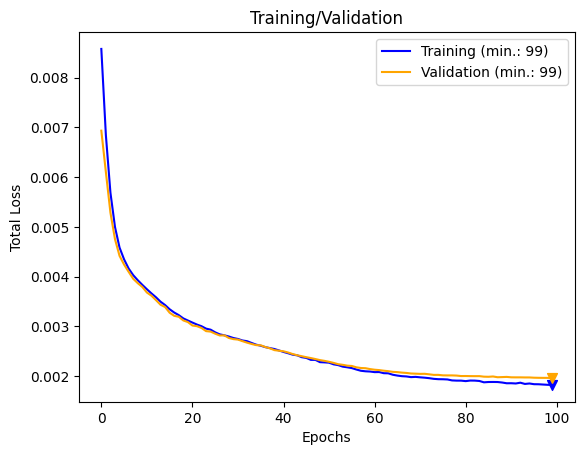

In [11]:
plots.plot_loss(output_train_data_npz_path=output_model_metrics_file)

***
<a id="featurize1"></a>
## Featurization of Evaluation dataset

**Downloading** the **trajectory** and **structure** for **Training**.

Trajectories where obtained from the [MDDB database](https://mmb-dev.mddbr.eu/#/).


In [12]:
# Downloading trajectory and structure for testing
traj_URL = "https://mmb.mddbr.eu/api/rest/v1/projects/MCV1900212/trajectory?format=xtc&frames=1-10000&selection=backbone%20and%20.CA"
pdb_URL = "https://mmb.mddbr.eu/api/rest/v1/projects/MCV1900212/structure?selection=backbone%20and%20.CA"
Path(test_trj_in).parent.mkdir(parents=True, exist_ok=True)
req = requests.get(traj_URL, allow_redirects=True)
open(test_trj_in, 'wb').write(req.content)
req = requests.get(pdb_URL, allow_redirects=True)
open(test_str_in, 'wb').write(req.content)

# Load trajectory
test_traj = md.load(test_trj_in, top=test_str_in)

### Visualizing 3D structure
Visualizing the **trajectory** using **NGL**:

In [13]:
# Show trajectory
view = nv.show_mdtraj(test_traj)
view

NGLWidget(max_frame=9999)

### Fit the trajectory

The **BioBB Analysis** tools are used to properly align the system to the **apo** structure.


***
**Biobb modules** used:
* [biobb_analysis](https://github.com/bioexcel/biobb_analysis)

***

In [14]:
from biobb_analysis.gromacs.gmx_image import gmx_image

traj_test_fit_path = "trajs/6W9C_holo_fit.xtc"

prop = {
    'fit_selection': 'Backbone',
    'output_selection': 'System',
    'center': False,
    'fit': 'rot+trans'
}

gmx_image(input_traj_path=test_trj_in,
          input_top_path=structure_train_path,
          output_traj_path=traj_test_fit_path,
          properties=prop)

2025-10-31 12:10:19,587 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_image Version: 5.1.2


INFO:log.out:Module: biobb_analysis.gromacs.gmx_image Version: 5.1.2


2025-10-31 12:10:19,588 [MainThread  ] [INFO ]  Directory successfully created: /content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23


INFO:log.out:Directory successfully created: /content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23


2025-10-31 12:10:19,590 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo.xtc --> sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo.xtc --> sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23


2025-10-31 12:10:19,599 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_apo.pdb --> sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_apo.pdb --> sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23


2025-10-31 12:10:19,600 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/99eea2a2-4d85-4e93-aea1-81f35d7a95b0.stdin --> sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/99eea2a2-4d85-4e93-aea1-81f35d7a95b0.stdin --> sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23


2025-10-31 12:10:19,602 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx trjconv -f /content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23/6W9C_holo.xtc -s /content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23/6W9C_apo.pdb -fit rot+trans -o /content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23/6W9C_holo_fit.xtc -nocenter < /content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23/99eea2a2-4d85-4e93-aea1-81f35d7a95b0.stdin


INFO:log.out:Launching command (it may take a while): gmx trjconv -f /content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23/6W9C_holo.xtc -s /content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23/6W9C_apo.pdb -fit rot+trans -o /content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23/6W9C_holo_fit.xtc -nocenter < /content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23/99eea2a2-4d85-4e93-aea1-81f35d7a95b0.stdin


2025-10-31 12:10:20,280 [MainThread  ] [INFO ]  Command 'gmx trjconv -f /content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c...' finalized with exit code 0


INFO:log.out:Command 'gmx trjconv -f /content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c...' finalized with exit code 0


2025-10-31 12:10:20,281 [MainThread  ] [INFO ]  Note that major changes are planned in future for trjconv, to improve usability and utility.

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Select group for least squares fit
Selected 4: 'Backbone'
Select group for output
Selected 0: 'System'



INFO:log.out:Note that major changes are planned in future for trjconv, to improve usability and utility.

         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Select group for least squares fit
Selected 4: 'Backbone'
Select group for output
Selected 0: 'System'



2025-10-31 12:10:20,282 [MainThread  ] [INFO ]               :-) GROMACS - gmx trjconv, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pasca

INFO:log.err:             :-) GROMACS - gmx trjconv, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhof

2025-10-31 12:10:20,295 [MainThread  ] [INFO ]  Removed: ['/content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23', '/content/biobb_wf_autoencoder/99eea2a2-4d85-4e93-aea1-81f35d7a95b0.stdin']


INFO:log.out:Removed: ['/content/biobb_wf_autoencoder/sandbox_22f8e4a3-b06a-4872-917b-42c00f0b5e23', '/content/biobb_wf_autoencoder/99eea2a2-4d85-4e93-aea1-81f35d7a95b0.stdin']


2025-10-31 12:10:20,296 [MainThread  ] [INFO ]  


INFO:log.out:


0

### MD Featurization

**Input parameters** needed:

* **input_trajectory_path** *(str)*: Path to the input train data file (i.e. pdb, dcd).
* **input_topology_path** *(str)*: Path to the input model file (i.e. pdb).
* **output_dataset_pt_path** *(str)*: Path to the output model file.
* **output_stats_pt_path** *(str)*: Path to the output model statistics file.

**properties parameters**:
>* **cartesian** (*dict*): select the atoms for obtaining cartesian coordinates
>* **distances** (*dict*): select the atoms for obtaining distances
>* **angles** (*dict*): select the atoms for obtaining angles
>* **dihedrals** (*dict*): select the atoms for obtaining dihedrals
>* **options** (*dict*):
    > * timelag (*int*)
    > * norm_in (*str*)



***

**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***


In [15]:
from biobb_pytorch.mdae.mdfeaturizer import MDFeaturizer

# Input files
trajectory_file = traj_test_fit_path
topology_file = test_str_in

# Output files
output_dataset_file = "6W9C_holo.pt"
output_stats_file = "6W9C_holo_stats.pt"

properties = {
    'cartesian': {'selection': 'name CA'},

    'remove_tmp': True,
    'disable_sandbox': True,
}

MDFeaturizer(
    input_trajectory_path=trajectory_file,
    input_topology_path=topology_file,
    output_dataset_pt_path=output_dataset_file,
    output_stats_pt_path=output_stats_file,
    properties=properties
)

2025-10-31 12:10:20,305 [MainThread  ] [INFO ]  ## BioBB Featurization - MDFeaturePipeline ##


/usr/local/lib/python3.12/dist-packages/biobb_common/tools/file_utils.py:817: UserWarning: biobb_pytorch.mdae.mdfeaturizer input_trajectory_path: trajs/6W9C_holo_fit.xtc extension is not in the valid extensions list: ['dcd']. If you want to suppress this message, please set the check_extensions property to False
  warnings.warn(not_valid_extension_error_string)
INFO:log.out:## BioBB Featurization - MDFeaturePipeline ##


2025-10-31 12:10:20,306 [MainThread  ] [INFO ]  Obtaining the topology information from trajs/6W9C_holo.pdb


INFO:log.out:Obtaining the topology information from trajs/6W9C_holo.pdb


2025-10-31 12:10:20,325 [MainThread  ] [INFO ]  Available Topology Properties:


INFO:log.out:Available Topology Properties:


2025-10-31 12:10:20,326 [MainThread  ] [INFO ]    - Number of chains: 1


INFO:log.out:  - Number of chains: 1


2025-10-31 12:10:20,326 [MainThread  ] [INFO ]    - Number of residues: 312


INFO:log.out:  - Number of residues: 312


2025-10-31 12:10:20,328 [MainThread  ] [INFO ]    - Number of atoms: 312


INFO:log.out:  - Number of atoms: 312


2025-10-31 12:10:20,329 [MainThread  ] [INFO ]    - Number of distances: N/A


INFO:log.out:  - Number of distances: N/A


2025-10-31 12:10:20,330 [MainThread  ] [INFO ]    - Number of angles: N/A


INFO:log.out:  - Number of angles: N/A


2025-10-31 12:10:20,331 [MainThread  ] [INFO ]    - Number of dihedrals: N/A


INFO:log.out:  - Number of dihedrals: N/A


2025-10-31 12:10:20,599 [MainThread  ] [INFO ]  Available Trajectory Properties:


INFO:log.out:Available Trajectory Properties:


2025-10-31 12:10:20,600 [MainThread  ] [INFO ]     - Number of frames: 10000


INFO:log.out:   - Number of frames: 10000


2025-10-31 12:10:20,601 [MainThread  ] [INFO ]  Featurizing the trajectory trajs/6W9C_holo_fit.xtc


INFO:log.out:Featurizing the trajectory trajs/6W9C_holo_fit.xtc


2025-10-31 12:10:20,804 [MainThread  ] [INFO ]  Features:


INFO:log.out:Features:


2025-10-31 12:10:20,805 [MainThread  ] [INFO ]    Cartesian:


INFO:log.out:  Cartesian:


2025-10-31 12:10:20,806 [MainThread  ] [INFO ]     - Topology Selection: name CA


INFO:log.out:   - Topology Selection: name CA


2025-10-31 12:10:20,807 [MainThread  ] [INFO ]     - Number of features: 936


INFO:log.out:   - Number of features: 936


2025-10-31 12:10:20,809 [MainThread  ] [INFO ]    Distances:


INFO:log.out:  Distances:


2025-10-31 12:10:20,809 [MainThread  ] [INFO ]     - Topology Selection: None


INFO:log.out:   - Topology Selection: None


2025-10-31 12:10:20,810 [MainThread  ] [INFO ]     - Number of features: 0


INFO:log.out:   - Number of features: 0


2025-10-31 12:10:20,812 [MainThread  ] [INFO ]    Angles:


INFO:log.out:  Angles:


2025-10-31 12:10:20,813 [MainThread  ] [INFO ]     - Topology Selection: None


INFO:log.out:   - Topology Selection: None


2025-10-31 12:10:20,814 [MainThread  ] [INFO ]     - Number of features: 0


INFO:log.out:   - Number of features: 0


2025-10-31 12:10:20,815 [MainThread  ] [INFO ]    Dihedrals:


INFO:log.out:  Dihedrals:


2025-10-31 12:10:20,816 [MainThread  ] [INFO ]     - Topology Selection: None


INFO:log.out:   - Topology Selection: None


2025-10-31 12:10:20,817 [MainThread  ] [INFO ]     - Number of features: 0


INFO:log.out:   - Number of features: 0


2025-10-31 12:10:20,818 [MainThread  ] [INFO ]  Postprocessing:


INFO:log.out:Postprocessing:


2025-10-31 12:10:20,819 [MainThread  ] [INFO ]     - Normalization: None


INFO:log.out:   - Normalization: None


2025-10-31 12:10:20,820 [MainThread  ] [INFO ]     - Timelag: {}


INFO:log.out:   - Timelag: {}


2025-10-31 12:10:20,821 [MainThread  ] [INFO ]  Dataset Properties:


INFO:log.out:Dataset Properties:


2025-10-31 12:10:20,823 [MainThread  ] [INFO ]     - Dataset: dict_keys(['data'])


INFO:log.out:   - Dataset: dict_keys(['data'])


2025-10-31 12:10:20,824 [MainThread  ] [INFO ]     - Number of frames: 10000


INFO:log.out:   - Number of frames: 10000


2025-10-31 12:10:20,825 [MainThread  ] [INFO ]     - Number of features: 936


INFO:log.out:   - Number of features: 936


2025-10-31 12:10:20,828 [MainThread  ] [INFO ]  Module: biobb_pytorch.mdae.mdfeaturizer Version: 5.1.1


INFO:log.out:Module: biobb_pytorch.mdae.mdfeaturizer Version: 5.1.1


2025-10-31 12:10:21,327 [MainThread  ] [INFO ]  Dataset saved in .pt format in /content/biobb_wf_autoencoder/6W9C_holo.pt


INFO:log.out:Dataset saved in .pt format in /content/biobb_wf_autoencoder/6W9C_holo.pt


2025-10-31 12:10:21,328 [MainThread  ] [INFO ]  File size: 53.92 MB


INFO:log.out:File size: 53.92 MB


2025-10-31 12:10:21,337 [MainThread  ] [INFO ]  Dataset statistics saved in .pt format in /content/biobb_wf_autoencoder/6W9C_holo_stats.pt


INFO:log.out:Dataset statistics saved in .pt format in /content/biobb_wf_autoencoder/6W9C_holo_stats.pt


2025-10-31 12:10:21,338 [MainThread  ] [INFO ]  File size: 76.8 KB


INFO:log.out:File size: 76.8 KB


2025-10-31 12:10:21,340 [MainThread  ] [INFO ]  


INFO:log.out:


0

***
<a id="evaluate-model"></a>
## Evaluate Model

**Input parameters**:
* **input_model_pth_path** *(str)*: Path to the input model file.
* **input_dataset_pt_path** *(str)*: Path to the input dataset file.
* **output_results_npz_path** *(str)*: Path to the output results file.

**Properties parameters**:
* **Dataset** (*dict*): Dataset options.

***
**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***



In [16]:
from biobb_pytorch.mdae.evaluate_model import evaluateModel

# Inputs
input_model_pth_path = "apo_trained_model.pth"
input_dataset_pt_path = "6W9C_apo.pt"

# Outputs
output_model_results_file = "apo_eval_results.npz"

properties = {
    'Dataset': {
        'batch_size': 64,

        }
    }

evaluateModel(
    input_model_pth_path=input_model_pth_path,
    input_dataset_pt_path=input_dataset_pt_path,
    output_results_npz_path=output_model_results_file,
    properties=properties
)


2025-10-31 12:10:21,349 [MainThread  ] [INFO ]  ## BioBB Model Evaluator ##


INFO:log.out:## BioBB Model Evaluator ##


2025-10-31 12:10:21,350 [MainThread  ] [INFO ]  Module: biobb_pytorch.mdae.evaluate_model Version: 5.1.1


INFO:log.out:Module: biobb_pytorch.mdae.evaluate_model Version: 5.1.1


2025-10-31 12:10:21,351 [MainThread  ] [INFO ]  Directory successfully created: /content/biobb_wf_autoencoder/sandbox_6a0b855d-12c5-4887-ba42-dda525be9ea0


INFO:log.out:Directory successfully created: /content/biobb_wf_autoencoder/sandbox_6a0b855d-12c5-4887-ba42-dda525be9ea0


2025-10-31 12:10:21,352 [MainThread  ] [INFO ]  Copy to stage: apo_trained_model.pth --> sandbox_6a0b855d-12c5-4887-ba42-dda525be9ea0


INFO:log.out:Copy to stage: apo_trained_model.pth --> sandbox_6a0b855d-12c5-4887-ba42-dda525be9ea0


2025-10-31 12:10:21,362 [MainThread  ] [INFO ]  Copy to stage: 6W9C_apo.pt --> sandbox_6a0b855d-12c5-4887-ba42-dda525be9ea0


INFO:log.out:Copy to stage: 6W9C_apo.pt --> sandbox_6a0b855d-12c5-4887-ba42-dda525be9ea0


2025-10-31 12:10:21,389 [MainThread  ] [INFO ]  Load model from /content/biobb_wf_autoencoder/apo_trained_model.pth


INFO:log.out:Load model from /content/biobb_wf_autoencoder/apo_trained_model.pth


2025-10-31 12:10:21,406 [MainThread  ] [INFO ]  Load dataset from /content/biobb_wf_autoencoder/6W9C_apo.pt


INFO:log.out:Load dataset from /content/biobb_wf_autoencoder/6W9C_apo.pt


2025-10-31 12:10:21,794 [MainThread  ] [INFO ]  Start evaluating...


INFO:log.out:Start evaluating...
/usr/local/lib/python3.12/dist-packages/lightning/pytorch/core/module.py:449: You are trying to `self.log()` but the `self.trainer` reference is not registered on the model yet. This is most likely because the model hasn't been passed to the `Trainer`


2025-10-31 12:10:25,140 [MainThread  ] [INFO ]  Evaluation Results saved to /content/biobb_wf_autoencoder/apo_eval_results.npz


INFO:log.out:Evaluation Results saved to /content/biobb_wf_autoencoder/apo_eval_results.npz


2025-10-31 12:10:25,141 [MainThread  ] [INFO ]  File size: 33.18 MB


INFO:log.out:File size: 33.18 MB


2025-10-31 12:10:25,153 [MainThread  ] [INFO ]  Removed: ['/content/biobb_wf_autoencoder/sandbox_6a0b855d-12c5-4887-ba42-dda525be9ea0']


INFO:log.out:Removed: ['/content/biobb_wf_autoencoder/sandbox_6a0b855d-12c5-4887-ba42-dda525be9ea0']


2025-10-31 12:10:25,154 [MainThread  ] [INFO ]  


INFO:log.out:


0

***
<a id="case-study"></a>
## Case Study: Dynamical Differences Mapping

This case study focuses on understanding the **dynamic behaviors** of **proteins** under two different conditions: **apo** (unbound) and **holo** (ligand-bound). By comparing **Root Mean Square Fluctuation (RMSF)** of both systems we obtain **insights** of the **dynamic changes** that occur when a **perturbations** are applied.

The study involves **comparing** **input trajectories** versus **reconstructed trajectories** using the **autoencoder model**, specifically within the context of **anomaly detection** in **protein dynamics**. The autoencoder model is **trained** exclusively on trajectories under the **apo condition**, which enables the model to learn the **apo condition dynamics** of the unbound protein form.

For **evaluation**, the model is presented with a **holo condition trajectory**, where the protein is bound to a ligand. We aim to **reconstruct** the **holo condition trajectory** with an **apo form trained model**. Discrepancies and deviations in the **reconstruction** can **reveal important insights** into the **dynamics** and **functional implications** of the protein under study.

### Index NDX file generation

The **BioBB GROMACS** tools are used to generate the **index file** for the **apo** and **holo** structures. This files are used for the RMSF calculations in the next cell.

***
**Biobb modules** used:
* [biobb_gromacs](https://github.com/bioexcel/biobb_gromacs)

***

In [17]:
from biobb_gromacs.gromacs.make_ndx import make_ndx

input_structure_pdb_file = "trajs/6W9C_apo.pdb"
output_index_ndx_file = "trajs/6W9C_apo.ndx"

prop = { 'selection': 'a CA' }

make_ndx(input_structure_path=input_structure_pdb_file,
         output_ndx_path=output_index_ndx_file,
         properties=prop)

input_structure_pdb_file = "trajs/6W9C_holo.pdb"
output_index_ndx_file = "trajs/6W9C_holo.ndx"

prop = { 'selection': 'a CA' }

make_ndx(input_structure_path=input_structure_pdb_file,
         output_ndx_path=output_index_ndx_file,
         properties=prop)

INFO:log.out:Launching command (it may take a while): gmx -nobackup -nocopyright -version
INFO:log.out:Command 'gmx -nobackup -nocopyright -version...' finalized with exit code 0
INFO:log.out:                 :-) GROMACS - gmx, 2021.4-Ubuntu-2021.4-2 (-:

Executable:   /usr/bin/gmx
Data prefix:  /usr
Working dir:  /content/biobb_wf_autoencoder
Command line:
  gmx -nobackup -nocopyright -version

GROMACS version:    2021.4-Ubuntu-2021.4-2
Precision:          mixed
Memory model:       64 bit
MPI library:        thread_mpi
OpenMP support:     enabled (GMX_OPENMP_MAX_THREADS = 64)
GPU support:        disabled
SIMD instructions:  SSE4.1
FFT library:        fftw-3.3.8-sse2-avx
RDTSCP usage:       enabled
TNG support:        enabled
Hwloc support:      hwloc-2.5.0
Tracing support:    disabled
C compiler:         /usr/bin/cc GNU 11.2.0
C compiler flags:   -msse4.1 -Wno-missing-field-initializers -fexcess-precision=fast -funroll-all-loops -O3 -DNDEBUG
C++ compiler:       /usr/bin/c++ GNU 11.2.0

2025-10-31 12:10:25,187 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.make_ndx Version: 5.1.2


INFO:log.out:Module: biobb_gromacs.gromacs.make_ndx Version: 5.1.2


2025-10-31 12:10:25,189 [MainThread  ] [INFO ]  Directory successfully created: /content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21


INFO:log.out:Directory successfully created: /content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21


2025-10-31 12:10:25,190 [MainThread  ] [INFO ]  Copy to stage: trajs/6W9C_apo.pdb --> sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21


INFO:log.out:Copy to stage: trajs/6W9C_apo.pdb --> sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21


2025-10-31 12:10:25,191 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/b5e0cbac-23f2-463f-aa70-2dcf093c3d1e.stdin --> sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/b5e0cbac-23f2-463f-aa70-2dcf093c3d1e.stdin --> sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21


2025-10-31 12:10:25,193 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx -nobackup -nocopyright make_ndx -f /content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21/6W9C_apo.pdb -o /content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21/6W9C_apo.ndx < /content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21/b5e0cbac-23f2-463f-aa70-2dcf093c3d1e.stdin


INFO:log.out:Launching command (it may take a while): gmx -nobackup -nocopyright make_ndx -f /content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21/6W9C_apo.pdb -o /content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21/6W9C_apo.ndx < /content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21/b5e0cbac-23f2-463f-aa70-2dcf093c3d1e.stdin


2025-10-31 12:10:25,211 [MainThread  ] [INFO ]  Command 'gmx -nobackup -nocopyright make_ndx -f /content/biobb_wf_autoencoder/sandbox_2de...' finalized with exit code 0


INFO:log.out:Command 'gmx -nobackup -nocopyright make_ndx -f /content/biobb_wf_autoencoder/sandbox_2de...' finalized with exit code 0


2025-10-31 12:10:25,212 [MainThread  ] [INFO ]  Going to read 0 old index file(s)
Analysing residue names:
There are:   312    Protein residues
Analysing Protein...

  0 System              :   312 atoms
  1 Protein             :   312 atoms
  2 Protein-H           :   312 atoms
  3 C-alpha             :   312 atoms
  4 Backbone            :   312 atoms
  5 MainChain           :   312 atoms
  6 MainChain+Cb        :   312 atoms
  7 MainChain+H         :   312 atoms
  8 SideChain           :     0 atoms
  9 SideChain-H         :     0 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr        'splitat' nr    'h': help
 'r': residue              'res' nr         'chain' char
 "name": group             'case': case sensitive           'q': save and quit
 'ri': residue index

> 
Found 312 atoms with name CA

 10 CA                  :   312 at

INFO:log.out:Going to read 0 old index file(s)
Analysing residue names:
There are:   312    Protein residues
Analysing Protein...

  0 System              :   312 atoms
  1 Protein             :   312 atoms
  2 Protein-H           :   312 atoms
  3 C-alpha             :   312 atoms
  4 Backbone            :   312 atoms
  5 MainChain           :   312 atoms
  6 MainChain+Cb        :   312 atoms
  7 MainChain+H         :   312 atoms
  8 SideChain           :     0 atoms
  9 SideChain-H         :     0 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr        'splitat' nr    'h': help
 'r': residue              'res' nr         'chain' char
 "name": group             'case': case sensitive           'q': save and quit
 'ri': residue index

> 
Found 312 atoms with name CA

 10 CA                  :   312 atoms

> 



2025-10-31 12:10:25,213 [MainThread  ] [INFO ]               :-) GROMACS - gmx make_ndx, 2021.4-Ubuntu-2021.4-2 (-:

Executable:   /usr/bin/gmx
Data prefix:  /usr
Working dir:  /content/biobb_wf_autoencoder
Command line:
  gmx -nobackup -nocopyright make_ndx -f /content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21/6W9C_apo.pdb -o /content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21/6W9C_apo.ndx


Reading structure file

GROMACS reminds you: "We're Gonna Hit You Harder" (Scoter)




INFO:log.err:             :-) GROMACS - gmx make_ndx, 2021.4-Ubuntu-2021.4-2 (-:

Executable:   /usr/bin/gmx
Data prefix:  /usr
Working dir:  /content/biobb_wf_autoencoder
Command line:
  gmx -nobackup -nocopyright make_ndx -f /content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21/6W9C_apo.pdb -o /content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21/6W9C_apo.ndx


Reading structure file

GROMACS reminds you: "We're Gonna Hit You Harder" (Scoter)




2025-10-31 12:10:25,216 [MainThread  ] [INFO ]  Removed: ['/content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21', '/content/biobb_wf_autoencoder/b5e0cbac-23f2-463f-aa70-2dcf093c3d1e.stdin']


INFO:log.out:Removed: ['/content/biobb_wf_autoencoder/sandbox_2de098a8-6da0-45b5-a12b-1a381bc97e21', '/content/biobb_wf_autoencoder/b5e0cbac-23f2-463f-aa70-2dcf093c3d1e.stdin']


2025-10-31 12:10:25,219 [MainThread  ] [INFO ]  


INFO:log.out:
INFO:log.out:Launching command (it may take a while): gmx -nobackup -nocopyright -version
INFO:log.out:Command 'gmx -nobackup -nocopyright -version...' finalized with exit code 0
INFO:log.out:                 :-) GROMACS - gmx, 2021.4-Ubuntu-2021.4-2 (-:

Executable:   /usr/bin/gmx
Data prefix:  /usr
Working dir:  /content/biobb_wf_autoencoder
Command line:
  gmx -nobackup -nocopyright -version

GROMACS version:    2021.4-Ubuntu-2021.4-2
Precision:          mixed
Memory model:       64 bit
MPI library:        thread_mpi
OpenMP support:     enabled (GMX_OPENMP_MAX_THREADS = 64)
GPU support:        disabled
SIMD instructions:  SSE4.1
FFT library:        fftw-3.3.8-sse2-avx
RDTSCP usage:       enabled
TNG support:        enabled
Hwloc support:      hwloc-2.5.0
Tracing support:    disabled
C compiler:         /usr/bin/cc GNU 11.2.0
C compiler flags:   -msse4.1 -Wno-missing-field-initializers -fexcess-precision=fast -funroll-all-loops -O3 -DNDEBUG
C++ compiler:       /usr/bin/

2025-10-31 12:10:25,237 [MainThread  ] [INFO ]  Module: biobb_gromacs.gromacs.make_ndx Version: 5.1.2


INFO:log.out:Module: biobb_gromacs.gromacs.make_ndx Version: 5.1.2


2025-10-31 12:10:25,238 [MainThread  ] [INFO ]  Directory successfully created: /content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b


INFO:log.out:Directory successfully created: /content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b


2025-10-31 12:10:25,239 [MainThread  ] [INFO ]  Copy to stage: trajs/6W9C_holo.pdb --> sandbox_bb20fec2-0500-442a-8da7-634b8870409b


INFO:log.out:Copy to stage: trajs/6W9C_holo.pdb --> sandbox_bb20fec2-0500-442a-8da7-634b8870409b


2025-10-31 12:10:25,241 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/425bc500-e8c9-4e47-889c-903a8ebc05fd.stdin --> sandbox_bb20fec2-0500-442a-8da7-634b8870409b


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/425bc500-e8c9-4e47-889c-903a8ebc05fd.stdin --> sandbox_bb20fec2-0500-442a-8da7-634b8870409b


2025-10-31 12:10:25,242 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx -nobackup -nocopyright make_ndx -f /content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b/6W9C_holo.pdb -o /content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b/6W9C_holo.ndx < /content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b/425bc500-e8c9-4e47-889c-903a8ebc05fd.stdin


INFO:log.out:Launching command (it may take a while): gmx -nobackup -nocopyright make_ndx -f /content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b/6W9C_holo.pdb -o /content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b/6W9C_holo.ndx < /content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b/425bc500-e8c9-4e47-889c-903a8ebc05fd.stdin


2025-10-31 12:10:25,260 [MainThread  ] [INFO ]  Command 'gmx -nobackup -nocopyright make_ndx -f /content/biobb_wf_autoencoder/sandbox_bb2...' finalized with exit code 0


INFO:log.out:Command 'gmx -nobackup -nocopyright make_ndx -f /content/biobb_wf_autoencoder/sandbox_bb2...' finalized with exit code 0


2025-10-31 12:10:25,261 [MainThread  ] [INFO ]  Going to read 0 old index file(s)
Analysing residue names:
There are:   312    Protein residues
Analysing Protein...

  0 System              :   312 atoms
  1 Protein             :   312 atoms
  2 Protein-H           :   312 atoms
  3 C-alpha             :   312 atoms
  4 Backbone            :   312 atoms
  5 MainChain           :   312 atoms
  6 MainChain+Cb        :   312 atoms
  7 MainChain+H         :   312 atoms
  8 SideChain           :     0 atoms
  9 SideChain-H         :     0 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr        'splitat' nr    'h': help
 'r': residue              'res' nr         'chain' char
 "name": group             'case': case sensitive           'q': save and quit
 'ri': residue index

> 
Found 312 atoms with name CA

 10 CA                  :   312 at

INFO:log.out:Going to read 0 old index file(s)
Analysing residue names:
There are:   312    Protein residues
Analysing Protein...

  0 System              :   312 atoms
  1 Protein             :   312 atoms
  2 Protein-H           :   312 atoms
  3 C-alpha             :   312 atoms
  4 Backbone            :   312 atoms
  5 MainChain           :   312 atoms
  6 MainChain+Cb        :   312 atoms
  7 MainChain+H         :   312 atoms
  8 SideChain           :     0 atoms
  9 SideChain-H         :     0 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr        'splitat' nr    'h': help
 'r': residue              'res' nr         'chain' char
 "name": group             'case': case sensitive           'q': save and quit
 'ri': residue index

> 
Found 312 atoms with name CA

 10 CA                  :   312 atoms

> 



2025-10-31 12:10:25,262 [MainThread  ] [INFO ]               :-) GROMACS - gmx make_ndx, 2021.4-Ubuntu-2021.4-2 (-:

Executable:   /usr/bin/gmx
Data prefix:  /usr
Working dir:  /content/biobb_wf_autoencoder
Command line:
  gmx -nobackup -nocopyright make_ndx -f /content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b/6W9C_holo.pdb -o /content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b/6W9C_holo.ndx


Reading structure file

GROMACS reminds you: "We're Gonna Hit You Harder" (Scoter)




INFO:log.err:             :-) GROMACS - gmx make_ndx, 2021.4-Ubuntu-2021.4-2 (-:

Executable:   /usr/bin/gmx
Data prefix:  /usr
Working dir:  /content/biobb_wf_autoencoder
Command line:
  gmx -nobackup -nocopyright make_ndx -f /content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b/6W9C_holo.pdb -o /content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b/6W9C_holo.ndx


Reading structure file

GROMACS reminds you: "We're Gonna Hit You Harder" (Scoter)




2025-10-31 12:10:25,264 [MainThread  ] [INFO ]  Removed: ['/content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b', '/content/biobb_wf_autoencoder/425bc500-e8c9-4e47-889c-903a8ebc05fd.stdin']


INFO:log.out:Removed: ['/content/biobb_wf_autoencoder/sandbox_bb20fec2-0500-442a-8da7-634b8870409b', '/content/biobb_wf_autoencoder/425bc500-e8c9-4e47-889c-903a8ebc05fd.stdin']


2025-10-31 12:10:25,265 [MainThread  ] [INFO ]  


INFO:log.out:


0

### RMSF calculation: Apo vs Holo Trajectories

BioBB GROMACS tools are used to calculate the RMSF of the trajectories.


***
**Biobb modules** used:
* [biobb_analysis](https://github.com/bioexcel/biobb_analysis)

***


In [18]:
from biobb_analysis.gromacs.gmx_rmsf import gmx_rmsf

input_structure_pdb_file = "trajs/6W9C_apo.pdb"
input_traj_xtc_file = "trajs/6W9C_apo.xtc"
input_index_ndx_file = "trajs/6W9C_apo.ndx"

output_xvg_apo_file = "trajs/6W9C_apo_rmsf.xvg"

prop = {'xvg': 'xmgr', 'selection': 'Protein'}

gmx_rmsf(
       input_structure_path=input_structure_pdb_file,
       input_traj_path=input_traj_xtc_file,
       input_index_path=input_index_ndx_file,
       output_xvg_path=output_xvg_apo_file,
       properties=prop)

input_structure_pdb_file = "trajs/6W9C_holo.pdb"
input_traj_xtc_file = "trajs/6W9C_holo.xtc"
input_index_ndx_file = "trajs/6W9C_holo.ndx"

output_xvg_holo_file = "trajs/6W9C_holo_rmsf.xvg"

prop = {'xvg': 'xmgr', 'selection': 'Protein'}

gmx_rmsf(
       input_structure_path=input_structure_pdb_file,
       input_traj_path=input_traj_xtc_file,
       input_index_path=input_index_ndx_file,
       output_xvg_path=output_xvg_holo_file,
       properties=prop)

2025-10-31 12:10:25,275 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_rmsf Version: 5.1.2


INFO:log.out:Module: biobb_analysis.gromacs.gmx_rmsf Version: 5.1.2


2025-10-31 12:10:25,276 [MainThread  ] [INFO ]  Directory successfully created: /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c


INFO:log.out:Directory successfully created: /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c


2025-10-31 12:10:25,277 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_apo.pdb --> sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_apo.pdb --> sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c


2025-10-31 12:10:25,278 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_apo.xtc --> sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_apo.xtc --> sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c


2025-10-31 12:10:25,287 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_apo.ndx --> sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_apo.ndx --> sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c


2025-10-31 12:10:25,288 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/595fad37-1e4c-41c8-9978-fce4dbb101bf.stdin --> sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/595fad37-1e4c-41c8-9978-fce4dbb101bf.stdin --> sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c


2025-10-31 12:10:25,289 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx rmsf -s /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c/6W9C_apo.pdb -f /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c/6W9C_apo.xtc -o /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c/6W9C_apo_rmsf.xvg -xvg xmgr -n /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c/6W9C_apo.ndx < /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c/595fad37-1e4c-41c8-9978-fce4dbb101bf.stdin


INFO:log.out:Launching command (it may take a while): gmx rmsf -s /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c/6W9C_apo.pdb -f /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c/6W9C_apo.xtc -o /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c/6W9C_apo_rmsf.xvg -xvg xmgr -n /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c/6W9C_apo.ndx < /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c/595fad37-1e4c-41c8-9978-fce4dbb101bf.stdin


2025-10-31 12:10:25,745 [MainThread  ] [INFO ]  Command 'gmx rmsf -s /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d4021...' finalized with exit code 0


INFO:log.out:Command 'gmx rmsf -s /content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d4021...' finalized with exit code 0


2025-10-31 12:10:25,747 [MainThread  ] [INFO ]  
         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Selected 1: 'Protein'



INFO:log.out:
         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Selected 1: 'Protein'



2025-10-31 12:10:25,748 [MainThread  ] [INFO ]                 :-) GROMACS - gmx rmsf, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal

INFO:log.err:               :-) GROMACS - gmx rmsf, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff

2025-10-31 12:10:25,753 [MainThread  ] [INFO ]  Removed: ['/content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c', '/content/biobb_wf_autoencoder/595fad37-1e4c-41c8-9978-fce4dbb101bf.stdin']


INFO:log.out:Removed: ['/content/biobb_wf_autoencoder/sandbox_e8c70ab4-4c74-4690-a80f-7d402122924c', '/content/biobb_wf_autoencoder/595fad37-1e4c-41c8-9978-fce4dbb101bf.stdin']


2025-10-31 12:10:25,754 [MainThread  ] [INFO ]  


INFO:log.out:


2025-10-31 12:10:25,758 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_rmsf Version: 5.1.2


INFO:log.out:Module: biobb_analysis.gromacs.gmx_rmsf Version: 5.1.2


2025-10-31 12:10:25,759 [MainThread  ] [INFO ]  Directory successfully created: /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78


INFO:log.out:Directory successfully created: /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78


2025-10-31 12:10:25,761 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo.pdb --> sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo.pdb --> sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78


2025-10-31 12:10:25,762 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo.xtc --> sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo.xtc --> sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78


2025-10-31 12:10:25,771 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo.ndx --> sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo.ndx --> sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78


2025-10-31 12:10:25,772 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/96718ecf-1668-4a34-a542-20d9208ae2b8.stdin --> sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/96718ecf-1668-4a34-a542-20d9208ae2b8.stdin --> sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78


2025-10-31 12:10:25,773 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx rmsf -s /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78/6W9C_holo.pdb -f /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78/6W9C_holo.xtc -o /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78/6W9C_holo_rmsf.xvg -xvg xmgr -n /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78/6W9C_holo.ndx < /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78/96718ecf-1668-4a34-a542-20d9208ae2b8.stdin


INFO:log.out:Launching command (it may take a while): gmx rmsf -s /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78/6W9C_holo.pdb -f /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78/6W9C_holo.xtc -o /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78/6W9C_holo_rmsf.xvg -xvg xmgr -n /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78/6W9C_holo.ndx < /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78/96718ecf-1668-4a34-a542-20d9208ae2b8.stdin


2025-10-31 12:10:26,229 [MainThread  ] [INFO ]  Command 'gmx rmsf -s /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a...' finalized with exit code 0


INFO:log.out:Command 'gmx rmsf -s /content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a...' finalized with exit code 0


2025-10-31 12:10:26,230 [MainThread  ] [INFO ]  
         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Selected 1: 'Protein'



INFO:log.out:
         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Selected 1: 'Protein'



2025-10-31 12:10:26,231 [MainThread  ] [INFO ]                 :-) GROMACS - gmx rmsf, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal

INFO:log.err:               :-) GROMACS - gmx rmsf, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff

2025-10-31 12:10:26,236 [MainThread  ] [INFO ]  Removed: ['/content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78', '/content/biobb_wf_autoencoder/96718ecf-1668-4a34-a542-20d9208ae2b8.stdin']


INFO:log.out:Removed: ['/content/biobb_wf_autoencoder/sandbox_aec43738-cadd-4fe3-801b-43f44a7d4f78', '/content/biobb_wf_autoencoder/96718ecf-1668-4a34-a542-20d9208ae2b8.stdin']


2025-10-31 12:10:26,237 [MainThread  ] [INFO ]  


INFO:log.out:


0

#### Visualize the RMSF: Apo vs Holo Trajectories

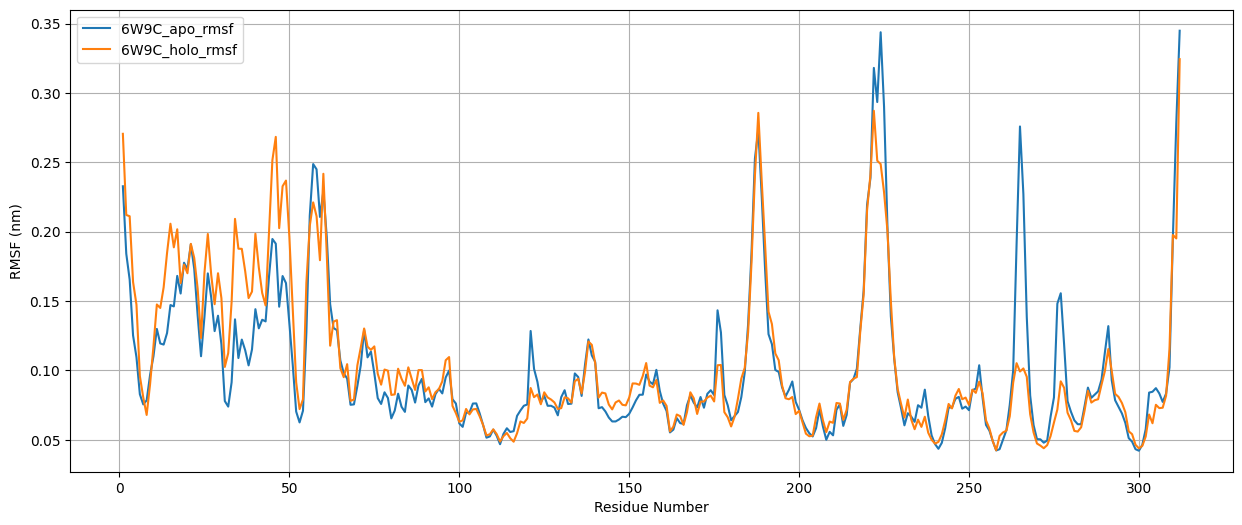

In [19]:
plots.plot_rmsf(input_xvg_path=[output_xvg_apo_file, output_xvg_holo_file])

### Dataset to Trajectory Conversion

Recover the **Cartesian coordinates** of the **Pytorch dataset file** (*features*) using cartesian indices and topology information in the statistics file.


           

**Input parameters**

* **input_results_npz_path** *(str)*: Path to the input results .npz file.
* **input_stats_pt_path** *(str)*: Path to the input model statistics file.
* **input_topology_path** *(str)*: Path to the input topology file (pdb).
* **output_traj_path** *(str)*: Path to save the trajectory in xtc/pdb/dcd format.
* **output_top_path** *(str)* (optional): Path to save the output topology file (pdb).

***
**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***

In [20]:
from biobb_pytorch.mdae.feat2traj import feat2traj

input_results_npz_path = "apo_eval_results.npz"
input_stats_pt_path = "6W9C_holo_stats.pt"
output_top_path = 'trajs/6W9C_holo_recon.pdb'
output_traj_path = "trajs/6W9C_holo_recon.xtc"

feat2traj(
    input_results_npz_path=input_results_npz_path,
    input_stats_pt_path=input_stats_pt_path,
    output_traj_path=output_traj_path,
    output_top_path=output_top_path
)


/usr/local/lib/python3.12/dist-packages/biobb_common/tools/file_utils.py:817: UserWarning: biobb_pytorch.mdae.feat2traj output_traj_path: trajs/6W9C_holo_recon.xtc extension is not in the valid extensions list: ['dcd']. If you want to suppress this message, please set the check_extensions property to False
  warnings.warn(not_valid_extension_error_string)


0

### RMSF calculation: Original Holo vs Reconstructed Holo Trajectories

**BioBB GROMACS** tools are used to calculate the RMSF of the **original Holo trajectory** and the **Autoencoder Reconstructed Holo Trajectory**.


***
**Biobb modules** used:
* [biobb_analysis](https://github.com/bioexcel/biobb_analysis)

***


In [21]:
from biobb_analysis.gromacs.gmx_rmsf import gmx_rmsf

input_structure_pdb_file = "trajs/6W9C_holo_recon.pdb"
input_traj_xtc_file = "trajs/6W9C_holo_recon.xtc"
input_index_ndx_file = "trajs/6W9C_holo.ndx"

output_xvg_holo_recon_file = "trajs/6W9C_holo_recon_rmsf.xvg"

prop = {'xvg': 'xmgr', 'selection': 'Protein'}

gmx_rmsf(
       input_structure_path=input_structure_pdb_file,
       input_traj_path=input_traj_xtc_file,
       input_index_path=input_index_ndx_file,
       output_xvg_path=output_xvg_holo_recon_file,
       properties=prop)

2025-10-31 12:10:26,844 [MainThread  ] [INFO ]  Module: biobb_analysis.gromacs.gmx_rmsf Version: 5.1.2


INFO:log.out:Module: biobb_analysis.gromacs.gmx_rmsf Version: 5.1.2


2025-10-31 12:10:26,845 [MainThread  ] [INFO ]  Directory successfully created: /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1


INFO:log.out:Directory successfully created: /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1


2025-10-31 12:10:26,846 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo_recon.pdb --> sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo_recon.pdb --> sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1


2025-10-31 12:10:26,847 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo_recon.xtc --> sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo_recon.xtc --> sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1


2025-10-31 12:10:26,855 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo.ndx --> sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/trajs/6W9C_holo.ndx --> sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1


2025-10-31 12:10:26,857 [MainThread  ] [INFO ]  Copy to stage: /content/biobb_wf_autoencoder/97d266d7-e05a-4b8f-9b88-d48022fd49ea.stdin --> sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1


INFO:log.out:Copy to stage: /content/biobb_wf_autoencoder/97d266d7-e05a-4b8f-9b88-d48022fd49ea.stdin --> sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1


2025-10-31 12:10:26,858 [MainThread  ] [INFO ]  Launching command (it may take a while): gmx rmsf -s /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1/6W9C_holo_recon.pdb -f /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1/6W9C_holo_recon.xtc -o /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1/6W9C_holo_recon_rmsf.xvg -xvg xmgr -n /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1/6W9C_holo.ndx < /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1/97d266d7-e05a-4b8f-9b88-d48022fd49ea.stdin


INFO:log.out:Launching command (it may take a while): gmx rmsf -s /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1/6W9C_holo_recon.pdb -f /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1/6W9C_holo_recon.xtc -o /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1/6W9C_holo_recon_rmsf.xvg -xvg xmgr -n /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1/6W9C_holo.ndx < /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1/97d266d7-e05a-4b8f-9b88-d48022fd49ea.stdin


2025-10-31 12:10:27,342 [MainThread  ] [INFO ]  Command 'gmx rmsf -s /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde...' finalized with exit code 0


INFO:log.out:Command 'gmx rmsf -s /content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde...' finalized with exit code 0


2025-10-31 12:10:27,343 [MainThread  ] [INFO ]  
         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Selected 1: 'Protein'



INFO:log.out:
         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

Selected 1: 'Protein'



2025-10-31 12:10:27,344 [MainThread  ] [INFO ]                 :-) GROMACS - gmx rmsf, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal

INFO:log.err:               :-) GROMACS - gmx rmsf, 2021.4-Ubuntu-2021.4-2 (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl            Magnus Lundborg             Erik Marklund       
        Pascal Merz             Pieter Meulenhoff

2025-10-31 12:10:27,348 [MainThread  ] [INFO ]  Removed: ['/content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1', '/content/biobb_wf_autoencoder/97d266d7-e05a-4b8f-9b88-d48022fd49ea.stdin']


INFO:log.out:Removed: ['/content/biobb_wf_autoencoder/sandbox_d1e4c8e8-41fd-45f7-bdf7-f76bde0a98c1', '/content/biobb_wf_autoencoder/97d266d7-e05a-4b8f-9b88-d48022fd49ea.stdin']


2025-10-31 12:10:27,349 [MainThread  ] [INFO ]  


INFO:log.out:


0

#### Visualizing RMSF: Original vs Reconstructed Trajectories

The **Root Mean Square Fluctuation (RMSF)** comparison between **original** and **reconstructed trajectories** using an **autoencoder** assesses the **variability of atomic fluctuation**, highlighting the discrepancies in atomic fluctuations, showcasing where the model may underrepresent or overrepresent the dynamic behavior of the molecular dynamic simulation. This comparison can pinpoint and map specific areas or residues with different dynamical behaviors between the two systems.

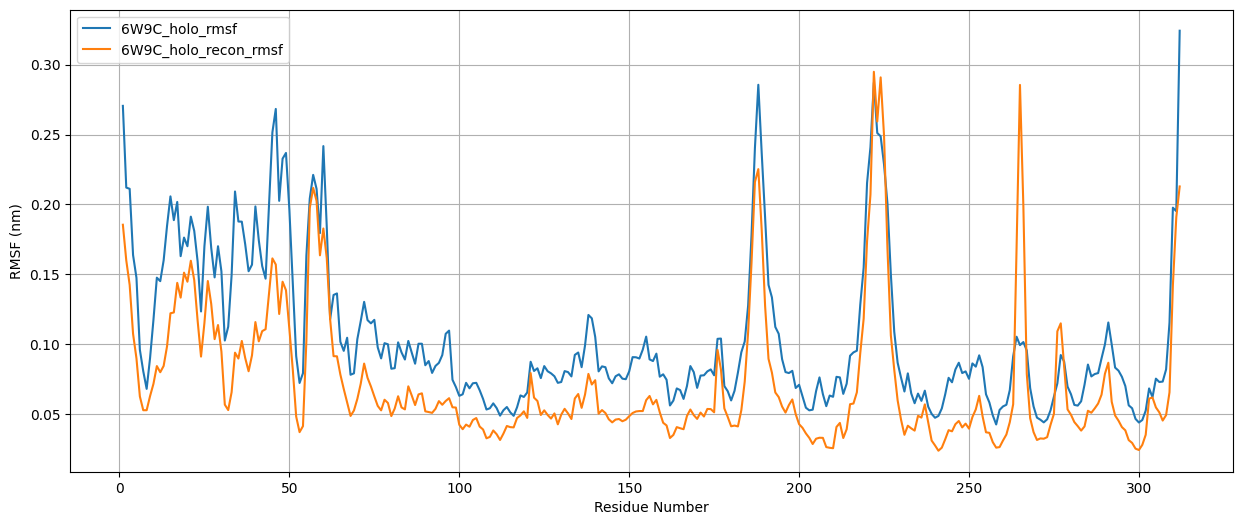

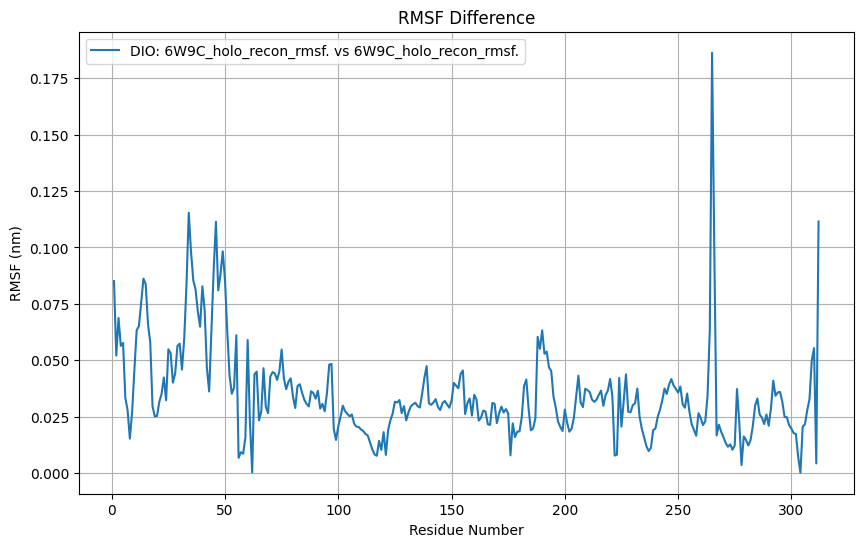

In [22]:
plots.plot_rmsf(input_xvg_path=[output_xvg_holo_file, output_xvg_holo_recon_file])
plots.plot_rmsf_difference(input_xvg_path=[output_xvg_holo_file, output_xvg_holo_recon_file])

#### Visualizing Latent Space Representation

The **2D latent space representation** of a dataset through an autoencoder visually condenses complex, **high-dimensional data** into **low-dimensional representation**. This reduced representation can reveal underlying structures and relationships within the data, essential for intuitive analysis and further scientific insights.

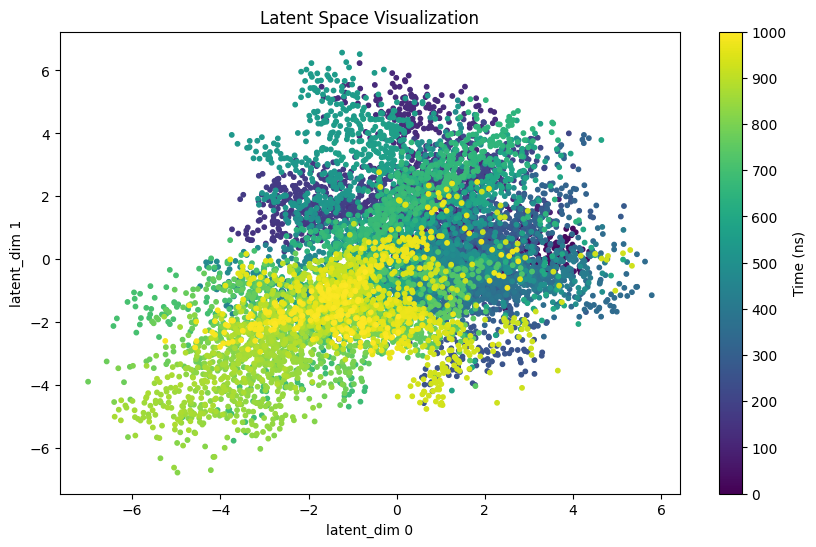

In [23]:
results_npz_file = "apo_eval_results.npz"

plots.plot_latent_space(results_npz_path=results_npz_file,
                  projection_dim=[0,1],
                  snapshot_freq_ps=10)

***
<a id="cv-plumed"></a>
## Extract CV & Generate Plumed File

Generates a **PLUMED input file**, **feature plumed file**, and converts the pytorch model into **PTC format**.

This setup enables **biased molecular dynamics simulations** by integrating the **neural network model** with **PLUMED** for **enhanced sampling**.


**Input parameters**:

* **input_model_pth_path** *(str)*: Path to the input PyTorch model file (.pth).
* **input_stats_pt_path** *(str)* (Optional): Path to the input statistics file (.pt) for non-Cartesian features.
* **input_reference_pdb_path** *(str)* (Optional): Path to the reference PDB file for Cartesian mode.
* **input_ndx_path** *(str)* (Optional): Path to the GROMACS NDX file.
* **output_plumed_dat_path** *(str)*: Path to the output PLUMED file.
* **output_features_dat_path** *(str)*: Path to the output features.dat file.
* **output_model_ptc_path** *(str)*: Path to the output TorchScript model file (.ptc).

**Properties parameters**
* **include_energy** (*bool*): Whether to include ENERGY in PLUMED.
* **biased** (*list*): List of biased dynamics commands.
* **prints** (*dict*): PRINT command parameters.
* **group** (*dict*): GROUP command parameters.
* **wholemolecules** (*dict*): WHOLEMOLECULES command parameters.
* **fit_to_template** (*dict*): FIT_TO_TEMPLATE command parameters.
* **pytorch_model** (*dict*): PYTORCH_MODEL command parameters.

***
**Biobb modules** used:
* [biobb_pytorch](https://github.com/bioexcel/biobb_pytorch)

***

In [24]:
from biobb_pytorch.mdae.make_plumed import generatePlumed

# Inputs
input_model_pth_file = "apo_trained_model.pth"
input_ndx_file = "trajs/6W9C_apo.ndx"
input_reference_pdb_file = "trajs/6W9C_apo.pdb"
input_stats_pt_file = "6W9C_apo_stats.pt"

# Outputs
output_model_ptc_file = "plumed_model.ptc"
output_plumed_file = "plumed.dat"
output_plumed_feature_file = "features.dat"

properties = {
                "additional_actions": [
                    {
                        "name": "ENERGY",
                        "label": "ene"
                    },
                ],
                "fit_to_template": {
                    "STRIDE": 1,
                    "TYPE": "OPTIMAL"
                },
                "group": {
                    "label": "backbone",
                    "selection": "backbone"
                },
                "bias": [
                    {
                        "name": "METAD",
                        "label": "bias",
                        "params": {
                            "ARG": "cv.*",
                            "PACE": 500,
                            "HEIGHT": 1.2,
                            "SIGMA": 0.35,
                            "FILE": "HILLS",
                            "BIASFACTOR": 8
                        }
                    }
                ],
                "prints": {
                    "ARG": "cv.*,bias.*",
                    "STRIDE": 1,
                    "FILE": "COLVAR"
                }
            }

generatePlumed(
    input_model_pth_path=input_model_pth_file,
    input_ndx_path=input_ndx_file,
    input_reference_pdb_path=input_reference_pdb_file,
    input_stats_pt_path=input_stats_pt_file,
    output_model_ptc_path=output_model_ptc_file,
    output_plumed_dat_path=output_plumed_file,
    output_features_dat_path=output_plumed_feature_file,
    properties=properties
)

2025-10-31 12:10:28,434 [MainThread  ] [INFO ]  Module: biobb_pytorch.mdae.make_plumed Version: 5.1.1


INFO:log.out:Module: biobb_pytorch.mdae.make_plumed Version: 5.1.1


2025-10-31 12:10:28,435 [MainThread  ] [INFO ]  Directory successfully created: /content/biobb_wf_autoencoder/sandbox_f3fd4012-b885-4f28-b656-85f2dd993dab


INFO:log.out:Directory successfully created: /content/biobb_wf_autoencoder/sandbox_f3fd4012-b885-4f28-b656-85f2dd993dab


2025-10-31 12:10:28,436 [MainThread  ] [INFO ]  Copy to stage: apo_trained_model.pth --> sandbox_f3fd4012-b885-4f28-b656-85f2dd993dab


INFO:log.out:Copy to stage: apo_trained_model.pth --> sandbox_f3fd4012-b885-4f28-b656-85f2dd993dab


2025-10-31 12:10:28,446 [MainThread  ] [INFO ]  Copy to stage: 6W9C_apo_stats.pt --> sandbox_f3fd4012-b885-4f28-b656-85f2dd993dab


INFO:log.out:Copy to stage: 6W9C_apo_stats.pt --> sandbox_f3fd4012-b885-4f28-b656-85f2dd993dab


2025-10-31 12:10:28,448 [MainThread  ] [INFO ]  Copy to stage: trajs/6W9C_apo.pdb --> sandbox_f3fd4012-b885-4f28-b656-85f2dd993dab


INFO:log.out:Copy to stage: trajs/6W9C_apo.pdb --> sandbox_f3fd4012-b885-4f28-b656-85f2dd993dab


2025-10-31 12:10:28,449 [MainThread  ] [INFO ]  Copy to stage: trajs/6W9C_apo.ndx --> sandbox_f3fd4012-b885-4f28-b656-85f2dd993dab


INFO:log.out:Copy to stage: trajs/6W9C_apo.ndx --> sandbox_f3fd4012-b885-4f28-b656-85f2dd993dab


2025-10-31 12:10:28,450 [MainThread  ] [INFO ]  Found 312 Cartesian features.


INFO:log.out:Found 312 Cartesian features.


2025-10-31 12:10:28,451 [MainThread  ] [INFO ]  Using GROUP: backbone


INFO:log.out:Using GROUP: backbone


2025-10-31 12:10:28,452 [MainThread  ] [INFO ]     Parameters:


INFO:log.out:   Parameters:


2025-10-31 12:10:28,454 [MainThread  ] [INFO ]      > SELECTION: backbone


INFO:log.out:    > SELECTION: backbone


2025-10-31 12:10:28,455 [MainThread  ] [INFO ]  WARNING: Using Cartesian coordinates but no WHOLEMOLECULES parameters provided; add WHOLEMOLECULES in properties.


INFO:log.out:WARNING: Using Cartesian coordinates but no WHOLEMOLECULES parameters provided; add WHOLEMOLECULES in properties.


2025-10-31 12:10:28,456 [MainThread  ] [INFO ]  Using FIT_TO_TEMPLATE


INFO:log.out:Using FIT_TO_TEMPLATE


2025-10-31 12:10:28,457 [MainThread  ] [INFO ]     Reference PDB: /content/biobb_wf_autoencoder/trajs/6W9C_apo.pdb


INFO:log.out:   Reference PDB: /content/biobb_wf_autoencoder/trajs/6W9C_apo.pdb


2025-10-31 12:10:28,457 [MainThread  ] [INFO ]     Parameters:


INFO:log.out:   Parameters:


2025-10-31 12:10:28,458 [MainThread  ] [INFO ]      > STRIDE: 1


INFO:log.out:    > STRIDE: 1


2025-10-31 12:10:28,459 [MainThread  ] [INFO ]      > TYPE: OPTIMAL


INFO:log.out:    > TYPE: OPTIMAL


2025-10-31 12:10:28,460 [MainThread  ] [INFO ]  Using PYTORCH_MODEL: cv


INFO:log.out:Using PYTORCH_MODEL: cv


2025-10-31 12:10:28,461 [MainThread  ] [INFO ]     Model ptc file: /content/biobb_wf_autoencoder/plumed_model.ptc


INFO:log.out:   Model ptc file: /content/biobb_wf_autoencoder/plumed_model.ptc


2025-10-31 12:10:28,461 [MainThread  ] [INFO ]  Using Bias:


INFO:log.out:Using Bias:


2025-10-31 12:10:28,462 [MainThread  ] [INFO ]     Command: METAD


INFO:log.out:   Command: METAD


2025-10-31 12:10:28,463 [MainThread  ] [INFO ]     Parameters:


INFO:log.out:   Parameters:


2025-10-31 12:10:28,464 [MainThread  ] [INFO ]      > ARG: cv.*


INFO:log.out:    > ARG: cv.*


2025-10-31 12:10:28,465 [MainThread  ] [INFO ]      > PACE: 500


INFO:log.out:    > PACE: 500


2025-10-31 12:10:28,466 [MainThread  ] [INFO ]      > HEIGHT: 1.2


INFO:log.out:    > HEIGHT: 1.2


2025-10-31 12:10:28,468 [MainThread  ] [INFO ]      > SIGMA: 0.35


INFO:log.out:    > SIGMA: 0.35


2025-10-31 12:10:28,469 [MainThread  ] [INFO ]      > FILE: HILLS


INFO:log.out:    > FILE: HILLS


2025-10-31 12:10:28,472 [MainThread  ] [INFO ]      > BIASFACTOR: 8


INFO:log.out:    > BIASFACTOR: 8


2025-10-31 12:10:28,474 [MainThread  ] [INFO ]  Generated features.dat at /content/biobb_wf_autoencoder/features.dat


INFO:log.out:Generated features.dat at /content/biobb_wf_autoencoder/features.dat


2025-10-31 12:10:28,475 [MainThread  ] [INFO ]  File size: 7.1 KB


INFO:log.out:File size: 7.1 KB


2025-10-31 12:10:28,476 [MainThread  ] [INFO ]  Generated PLUMED file at /content/biobb_wf_autoencoder/plumed.dat


INFO:log.out:Generated PLUMED file at /content/biobb_wf_autoencoder/plumed.dat


2025-10-31 12:10:28,477 [MainThread  ] [INFO ]  File size: 6.47 KB


INFO:log.out:File size: 6.47 KB


2025-10-31 12:10:28,482 [MainThread  ] [INFO ]  Removed: ['/content/biobb_wf_autoencoder/sandbox_f3fd4012-b885-4f28-b656-85f2dd993dab']


INFO:log.out:Removed: ['/content/biobb_wf_autoencoder/sandbox_f3fd4012-b885-4f28-b656-85f2dd993dab']


2025-10-31 12:10:28,483 [MainThread  ] [INFO ]  


INFO:log.out:


0

In [25]:
!cat plumed.dat

INCLUDE FILE=/content/biobb_wf_autoencoder/features.dat
ene: ENERGY 
backbone: GROUP selection=backbone
FIT_TO_TEMPLATE REFERENCE=/content/biobb_wf_autoencoder/trajs/6W9C_apo.pdb STRIDE=1 TYPE=OPTIMAL
cv: PYTORCH_MODEL FILE=/content/biobb_wf_autoencoder/plumed_model.ptc ARG=p1.x,p1.y,p1.z,p2.x,p2.y,p2.z,p3.x,p3.y,p3.z,p4.x,p4.y,p4.z,p5.x,p5.y,p5.z,p6.x,p6.y,p6.z,p7.x,p7.y,p7.z,p8.x,p8.y,p8.z,p9.x,p9.y,p9.z,p10.x,p10.y,p10.z,p11.x,p11.y,p11.z,p12.x,p12.y,p12.z,p13.x,p13.y,p13.z,p14.x,p14.y,p14.z,p15.x,p15.y,p15.z,p16.x,p16.y,p16.z,p17.x,p17.y,p17.z,p18.x,p18.y,p18.z,p19.x,p19.y,p19.z,p20.x,p20.y,p20.z,p21.x,p21.y,p21.z,p22.x,p22.y,p22.z,p23.x,p23.y,p23.z,p24.x,p24.y,p24.z,p25.x,p25.y,p25.z,p26.x,p26.y,p26.z,p27.x,p27.y,p27.z,p28.x,p28.y,p28.z,p29.x,p29.y,p29.z,p30.x,p30.y,p30.z,p31.x,p31.y,p31.z,p32.x,p32.y,p32.z,p33.x,p33.y,p33.z,p34.x,p34.y,p34.z,p35.x,p35.y,p35.z,p36.x,p36.y,p36.z,p37.x,p37.y,p37.z,p38.x,p38.y,p38.z,p39.x,p39.y,p39.z,p40.x,p40.y,p40.z,p41.x,p41.y,p41.z,p42.x,p42.y,p4

***
<a id="questions"></a>

## Questions & Comments

Questions, issues, suggestions and comments are really welcome!

* GitHub issues:
    * [https://github.com/bioexcel/biobb](https://github.com/bioexcel/biobb)

* BioExcel forum:
    * [https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library](https://ask.bioexcel.eu/c/BioExcel-Building-Blocks-library)
